In [1]:
from datasets import load_dataset
import pandas as pd

## Read the data
dataset = pd.DataFrame(load_dataset(path="ag_news")['train'],)

In [2]:
## Check 

dataset.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [3]:
## Shape of the data -- number of rows and columns 
dataset.shape

(120000, 2)

Abbiamo **120.000** righe, come indicato nella scheda Dataset della pagina di Huggingface.

* Viene anche menzionato che c'è una suddivisione equa tra le varie categorie di articoli, con una suddivisione del **25%** per ognuna della **4** classi. Verifichiamo di seguito.

In [4]:
dataset.label.value_counts()

label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

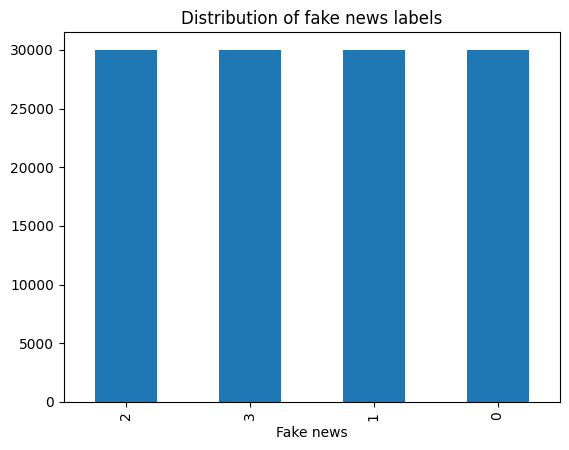

In [5]:
import matplotlib.pyplot as plt

dataset.label.value_counts().plot(kind = 'bar')
plt.xlabel("Fake news")
plt.title("Distribution of fake news labels")
plt.show()

In [6]:
## Check for missing data
dataset.isnull().sum()

text     0
label    0
dtype: int64

# Preprocessing

## Look at some examples of each class news 

### World news examples 

In [7]:
dataset[dataset.label == 0]

,text,label
492,Venezuelans Vote Early in Referendum on Chavez...,0
493,S.Koreans Clash with Police on Iraq Troop Disp...,0
494,Palestinians in Israeli Jails Start Hunger Str...,0
495,Seven Georgian soldiers wounded as South Osset...,0
496,Rwandan Troops Arrive in Darfur (AP) AP - Doze...,0
...,...,...
119990,Barack Obama Gets #36;1.9 Million Book Deal (...,0
119992,Iraqis Face Winter Shivering by Candlelight B...,0
119993,AU Says Sudan Begins Troop Withdrawal from Dar...,0
119994,Syria Redeploys Some Security Forces in Lebano...,0


### Sports news examples

In [8]:
dataset[dataset.label == 1]

,text,label
448,"Phelps, Thorpe Advance in 200 Freestyle (AP) A...",1
449,Reds Knock Padres Out of Wild-Card Lead (AP) A...,1
450,"Dreaming done, NBA stars awaken to harsh Olymp...",1
451,"Indians Beat Twins 7-1, Nearing AL Lead (AP) A...",1
452,"Galaxy, Crew Play to 0-0 Tie (AP) AP - Kevin H...",1
...,...,...
119991,Rauffer Beats Favorites to Win Downhill VAL G...,1
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


### Business news examples

In [9]:
dataset[dataset.label == 2]

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119977,"Despite Mega-Deals, Small Mergers Rule Philad...",2
119978,Wal-Mart Dec. Sales Still Seen Up 1-3 Pct CHI...,2
119979,Sabotage Stops Iraq's North Oil Exports BAGHD...,2
119980,Corporate Cost-Cutters Miss Out CHICAGO (Reut...,2


### Sci/Tech news examples

In [10]:
dataset[dataset.label == 3]

,text,label
78,"'Madden,' 'ESPN' Football Score in Different W...",3
79,Group to Propose New High-Speed Wireless Forma...,3
80,AOL to Sell Cheap PCs to Minorities and Senior...,3
81,Companies Approve New High-Capacity Disc Forma...,3
82,Missing June Deals Slow to Return for Software...,3
...,...,...
119940,"Naughty, nice are irrelevant if Santa can #39;...",3
119950,Digitized And Brought To Life Digital technolo...,3
119951,New Computer? Six Steps to Safer Surfing To se...,3
119952,Video Files Present A Search Challenge Indexin...,3


## CLEANING: Lowercasing + remove stop words + remove punctuation

In [11]:
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk
import time

## download the dictionary for stopwords
nltk.download('stopwords')

## get the set of stopwords 
stop_words_set = set(stopwords.words('english'))

## Load English tokenizer from spacy
nlp = English()
tokenizer = nlp.tokenizer ## make instance 

[nltk_data] Downloading package stopwords to /home/ale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
## Create function to clean text -- lowercase, remove non alphanumeric, remove stop words
def optimized_preprocess(texts): ## Takes in a list of texts, i.e. the entire corpus
    result = []
    
    # Tokenize using spacy's tokenizer
    for text in texts:
        tokens = [token.text.lower() for token in tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
        result.append(" ".join(tokens))
    
    return result

# Process data
s = time.time()
preprocessed_texts = optimized_preprocess(dataset.text)
print('Time to clean ', time.time() - s)

Time to clean  13.622709512710571


In [13]:
## Save a new column in the dataset
dataset['text_cleaned'] = preprocessed_texts

In [14]:
## Check cleaned text 
print(dataset.text_cleaned.head())

## Read some in full
print(dataset.text_cleaned[10][0:1000])

0    wall bears claw back black reuters reuters sho...
1    carlyle looks toward commercial aerospace reut...
2    oil economy cloud stocks outlook reuters reute...
3    iraq halts oil exports main southern pipeline ...
4    oil prices soar time record posing new menace ...
Name: text_cleaned, dtype: object
oil economy cloud stocks outlook new york reuters soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums


## Explore some differences between categories of texts

### Comparing choice of vocabulary

Contiamo la frequenza delle parole utilizzate nelle diverse categorie di notizie e confrontiamo le principali scelte di vocabolario tra di esse.

In [15]:
from collections import Counter ## for counting words 

## Get world, sports, business and tech subsets 
world_text = dataset[dataset.label == 0]["text_cleaned"]
sports_text = dataset[dataset.label == 1]["text_cleaned"]
business_text = dataset[dataset.label == 2]["text_cleaned"]
tech_text = dataset[dataset.label == 3]["text_cleaned"]

In [16]:
## Entire vocabulary 
vocab_set = set((" ".join(dataset.text_cleaned)).split())
non_unique_set = (" ".join(dataset.text_cleaned)).split()

In [17]:
## Get sizes of vocab, entire corpus, ratio 
print('Vocab size : ', len(vocab_set))
print('Entire word count : ', len(non_unique_set))
print('Ratio of word count to vocab size : ', len(non_unique_set)/len(vocab_set) )

Vocab size :  60571
Entire word count :  2942984
Ratio of word count to vocab size :  48.58734377837579


In media ogni parola viene usata 49 volte. 
* Vocab size ~ 61 k
* Entire corpus word count ~ 3 million

In [18]:
## COUNT THE WORDS

## First, turn a list of lists into just one list -- i.e. join all documents together into
## one giant document/ string
world_text_giant_string = " ".join(world_text)
print(len(world_text_giant_string))
sports_text_giant_string = " ".join(sports_text)
print(len(sports_text_giant_string))
business_text_giant_string = " ".join(business_text)
print(len(business_text_giant_string))
tech_text_giant_string = " ".join(tech_text)
print(len(tech_text_giant_string))


## Now, update to the Counter object to begin counting
world_words_counter = Counter(world_text_giant_string.split())
sports_words_counter = Counter(sports_text_giant_string.split())
business_words_counter = Counter(business_text_giant_string.split())
tech_words_counter = Counter(tech_text_giant_string.split())


5564649
4927336
5293240
5239805


## Counting the words used in different news categories

In [19]:
## See results
print(type(world_words_counter))
print(world_words_counter.most_common(10)) ## Most common words for world news
print(sports_words_counter.most_common(10)) ## Most common words for sports news
print(business_words_counter.most_common(10)) ## Most common words for business news
print(tech_words_counter.most_common(10)) ## Most common words for tech news

<class 'collections.Counter'>
[('said', 7663), ('iraq', 5812), ('ap', 5787), ('reuters', 5414), ('president', 4273), ('us', 4107), ('two', 3562), ('new', 3457), ('afp', 3386), ('minister', 3328)]
[('ap', 6262), ('game', 4267), ('first', 4235), ('new', 4148), ('season', 3636), ('team', 3489), ('win', 3484), ('two', 3339), ('one', 3221), ('night', 3081)]
[('said', 7228), ('reuters', 6898), ('new', 6611), ('oil', 6349), ('us', 5852), ('company', 4286), ('prices', 4202), ('percent', 3398), ('york', 3387), ('year', 3312)]
[('new', 7120), ('microsoft', 5104), ('ap', 3692), ('software', 3633), ('said', 3602), ('internet', 3328), ('reuters', 3262), ('company', 2891), ('space', 2332), ('search', 2279)]


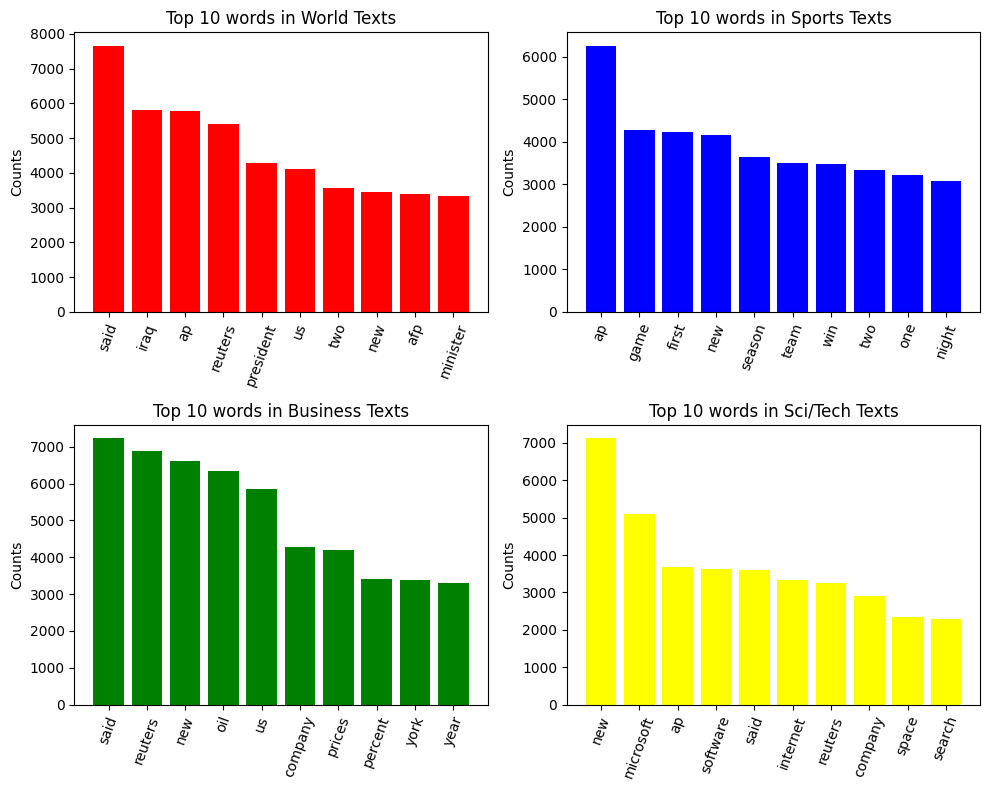

In [20]:
## Visualise the top words 

fake_top_10 = world_words_counter.most_common(10)
x1, y1 = zip(*fake_top_10)

true_top_10 = sports_words_counter.most_common(10)
x2, y2 = zip(*true_top_10)

fake_top_10 = business_words_counter.most_common(10)
x3, y3 = zip(*fake_top_10)

true_top_10 = tech_words_counter.most_common(10)
x4, y4 = zip(*true_top_10)

## Plot
# 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plotting world data
axs[0, 0].bar(x1, y1, color='red')
axs[0, 0].set_title('Top 10 words in World Texts')
axs[0, 0].tick_params(axis='x', rotation=70)
axs[0, 0].set_ylabel('Counts')

# Plotting sports data
axs[0, 1].bar(x2, y2, color='blue')
axs[0, 1].set_title('Top 10 words in Sports Texts')
axs[0, 1].tick_params(axis='x', rotation=70)
axs[0, 1].set_ylabel('Counts')

# Plotting business data
axs[1, 0].bar(x3, y3, color='green')
axs[1, 0].set_title('Top 10 words in Business Texts')
axs[1, 0].tick_params(axis='x', rotation=70)
axs[1, 0].set_ylabel('Counts')

# Plotting tech data
axs[1, 1].bar(x4, y4, color='yellow')
axs[1, 1].set_title('Top 10 words in Sci/Tech Texts')
axs[1, 1].tick_params(axis='x', rotation=70)
axs[1, 1].set_ylabel('Counts')

plt.tight_layout()
plt.show()

### Word clouds

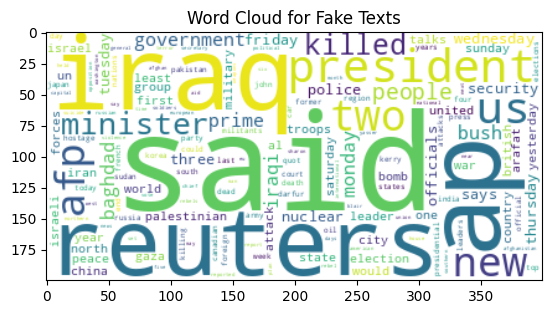

In [21]:
from wordcloud import WordCloud

world_WC = WordCloud(background_color = 'white').generate_from_frequencies(world_words_counter)

plt.imshow(world_WC, interpolation = 'bilinear')
plt.title('Word Cloud for Fake Texts')
plt.show()

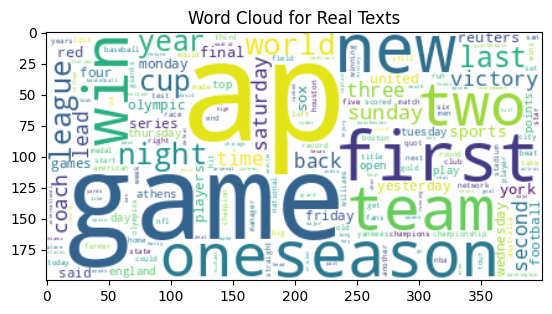

In [22]:
sports_WC = WordCloud(background_color = 'white').generate_from_frequencies(sports_words_counter)

plt.imshow(sports_WC, interpolation = 'bilinear')
plt.title('Word Cloud for Real Texts')
plt.show()

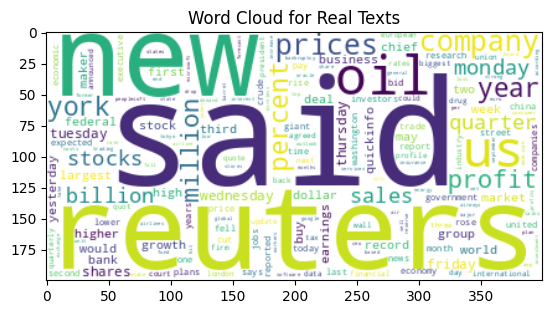

In [23]:
business_WC = WordCloud(background_color = 'white').generate_from_frequencies(business_words_counter)

plt.imshow(business_WC, interpolation = 'bilinear')
plt.title('Word Cloud for Real Texts')
plt.show()

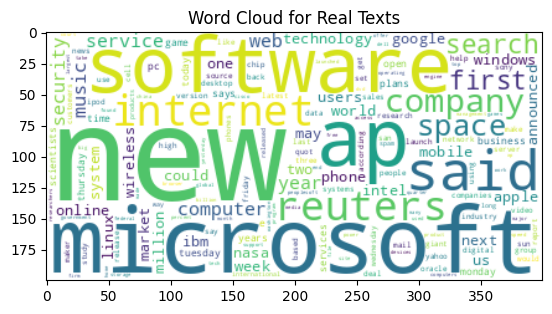

In [24]:
tech_WC = WordCloud(background_color = 'white').generate_from_frequencies(tech_words_counter)

plt.imshow(tech_WC, interpolation = 'bilinear')
plt.title('Word Cloud for Real Texts')
plt.show()

## Length of documents 

In [25]:
world_lengths = world_text.str.split().apply(len)
print(world_lengths)

sports_lengths = sports_text.str.split().apply(len)
print(sports_lengths)

business_lengths = business_text.str.split().apply(len)
print(business_lengths)

tech_lengths = tech_text.str.split().apply(len)
print(tech_lengths)

492       27
493       23
494       22
495       28
496       31
          ..
119990    28
119992    26
119993    25
119994    25
119995    24
Name: text_cleaned, Length: 30000, dtype: int64
448       39
449       40
450       32
451       34
452       24
          ..
119991    29
119996    33
119997    29
119998    38
119999    26
Name: text_cleaned, Length: 30000, dtype: int64
0         15
1         23
2         21
3         24
4         30
          ..
119977    26
119978    33
119979    27
119980    27
119981    28
Name: text_cleaned, Length: 30000, dtype: int64
78        29
79        24
80        23
81        27
82        26
          ..
119940    21
119950    29
119951    34
119952    24
119954    16
Name: text_cleaned, Length: 30000, dtype: int64


### Visualize differences in length

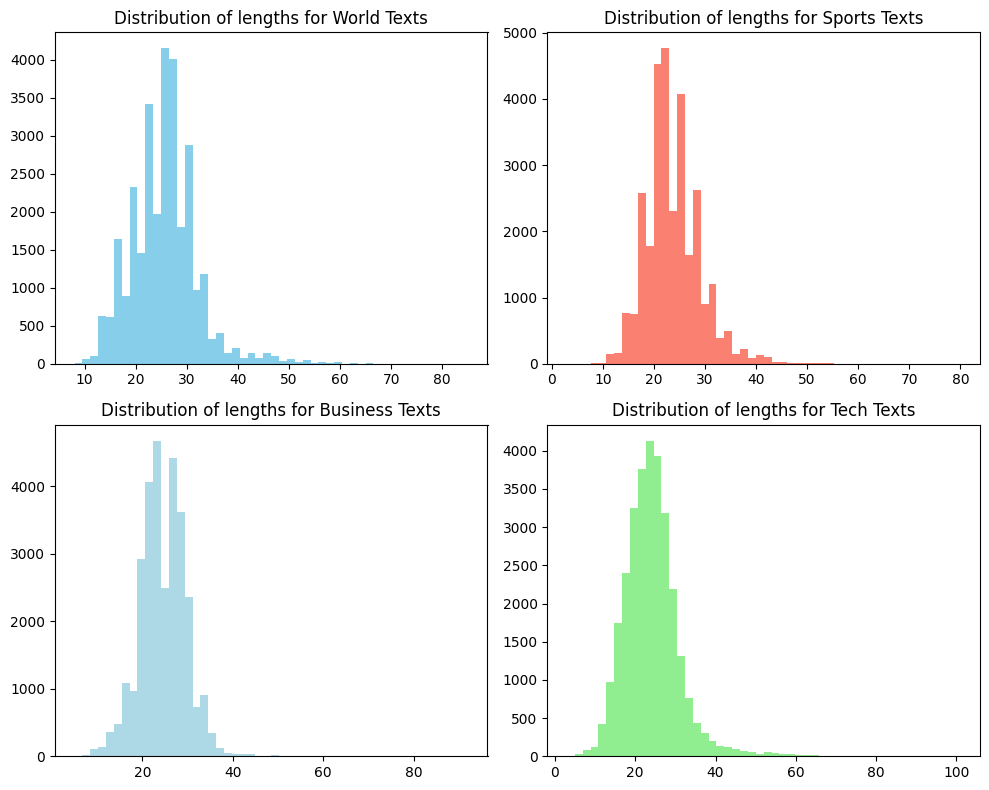

In [26]:
# 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Fake one
axs[0, 0].hist(world_lengths, bins=50, color='skyblue')
axs[0, 0].set_title('Distribution of lengths for World Texts')

# Sports one
axs[0, 1].hist(sports_lengths, bins=50, color='salmon')
axs[0, 1].set_title('Distribution of lengths for Sports Texts')

# Business one
axs[1, 0].hist(business_lengths, bins=50, color='lightblue')
axs[1, 0].set_title('Distribution of lengths for Business Texts')

# Tech one
axs[1, 1].hist(tech_lengths, bins=50, color='lightgreen')
axs[1, 1].set_title('Distribution of lengths for Tech Texts')


plt.tight_layout()
plt.show()


Come è possibile notare abbiamo gaussiane con distribuzioni simili tra loro con documenti che in media hanno tra i 20/25 termini per documento, pertanto la lunghezza non può essere un discriminante per la classificazione

# Feature engineering: modello Bags of Words

I modelli di NLP non possono ricevere testo grezzo, poiché i modelli di machine learning comprendono solo numeri e vettori. Per inserire i nostri dati sulle notizie in un modello dobbiamo prima convertire il testo in qualcosa di vettoriale, e un'opzione è il modello **BoW** (Bags of Words).

Il modello **BoW** tratta il testo come un insieme non ordinato di parole, dove l'ordine non conta. Possiamo già vedere come questa sia una limitazione ovvia, ma può essere il primo passo avanti.

La prima cosa che fa BoW è **creare un vocabolario di tutte le parole**. Questo diventerà essenzialmente il nostro insieme di predittori, cioè ogni parola è un predittore o una **feature** (ad esempio, come l'istruzione, l'età, l'industria sono predittori per la previsione del salario). In questo caso, ogni documento è un campione, rappresentato da un vettore la cui lunghezza è uguale alla dimensione del vocabolario. Ogni entry corrisponde al numero di parole per quel predittore di parola unica del documento particolare; ovvero, l'elemento i, j-esimo corrisponde alla frequenza della j-esima parola per l'i-esimo documento.

## Transforming text to BoW -- Count Vectorizer 

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

## Instantiate vectorizer 
vectorizer = CountVectorizer()

In [28]:
## Save text
preprocessed_text = dataset.text_cleaned

## Apply vectorizer to get the bag of words matrix
X = vectorizer.fit_transform(preprocessed_text)

In [29]:
## Shape
print(X.shape)

(120000, 60553)


## Display of count vectorized data -- BoW

In [30]:
vocab = vectorizer.vocabulary_

print(type(vocab))
print(len(vocab))

## Sum the occurrences of the words across the rows of the matrix
df_count = X.sum(axis=0).A1

countvect_df = pd.DataFrame(list(zip(vocab.keys(), df_count)), ## extract out the items from the dictionary so that we can turn it into a pandas dataframe
                           columns = ['word', 'count'])

print(countvect_df.sort_values('count', ascending = False))

<class 'dict'>
60553
               word  count
36205       schuler  21336
46365  newsmagazine  19995
45013        someon  17255
2355         starts  16249
56959         neely  12820
...             ...    ...
64             soar      1
60486      mannings      1
60491         bubin      1
47            depth      1
49             iraq      1

[60553 rows x 2 columns]


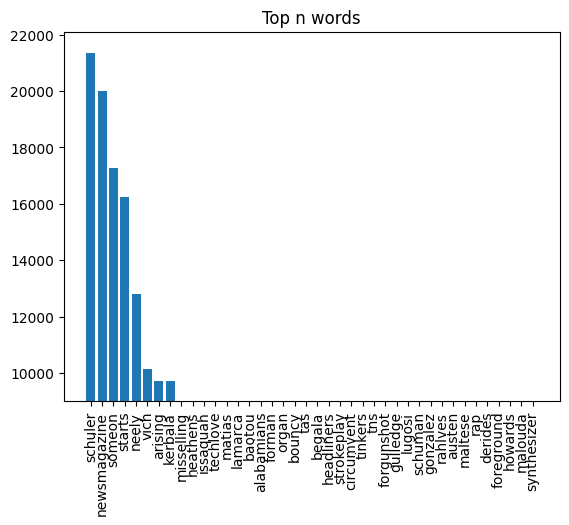

In [31]:
## Get top ten words to visualize 
n = 40
top_words_from_countvec = countvect_df.sort_values('count', ascending = False).head(n)

## Plot
plt.bar(top_words_from_countvec['word'], top_words_from_countvec['count'])
plt.ylim([9000, 22000 + 100])
plt.xticks(rotation = 90)
plt.title("Top n words")
plt.show()

In [32]:
vectorizer.vocabulary_

{'wall': 58216,
 'bears': 4677,
 'claw': 9773,
 'back': 3811,
 'black': 5602,
 'reuters': 45013,
 'short': 48526,
 'sellers': 47681,
 'street': 51605,
 'ultra': 55951,
 'cynics': 12675,
 'seeing': 47588,
 'green': 22332,
 'carlyle': 8203,
 'looks': 31195,
 'toward': 54816,
 'commercial': 10487,
 'aerospace': 803,
 'private': 41721,
 'investment': 26968,
 'firm': 19297,
 'reputation': 44649,
 'making': 31949,
 'well': 58735,
 'timed': 54305,
 'plays': 40534,
 'defense': 13399,
 'industry': 26088,
 'quietly': 42757,
 'bets': 5206,
 'another': 2192,
 'part': 39062,
 'market': 32392,
 'oil': 37453,
 'economy': 16210,
 'cloud': 9964,
 'stocks': 51392,
 'outlook': 38208,
 'soaring': 49777,
 'crude': 12284,
 'prices': 41626,
 'plus': 40669,
 'earnings': 16050,
 'expected': 18002,
 'stock': 51374,
 'next': 36309,
 'week': 58651,
 'depth': 13855,
 'doldrums': 15162,
 'iraq': 27084,
 'halts': 23069,
 'exports': 18101,
 'main': 31887,
 'southern': 50140,
 'pipeline': 40279,
 'authorities': 3512,


## Train test split

Dividiamo in train e test in proporzione 80-20

In [33]:
from sklearn.model_selection import train_test_split

y = dataset['label']  # Assuming 'label' is the column with classes' labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
## Check dimensions

print('Train set ', X_train.shape)
print('Test set ', X_test.shape)

Train set  (96000, 60553)
Test set  (24000, 60553)


# First set: Use different models on BOW 

## BOW 1: MultinomialNB

In [35]:
## TRAIN
from sklearn.naive_bayes import MultinomialNB

s = time.time()
multiNB_clf = MultinomialNB()
multiNB_clf.fit(X_train, y_train)
time_for_multiNB = time.time() - s
print("Time to fit Multinomial NaiveBayes:", time_for_multiNB )

Time to fit logistic regression : 0.026168107986450195


In [36]:
## Evaluate 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_multiNB = multiNB_clf.predict(X_test)
acc_bow_multiNB = accuracy_score(y_test, y_pred_multiNB)
print(classification_report(y_test, y_pred_multiNB))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      5956
           1       0.95      0.98      0.96      6058
           2       0.87      0.87      0.87      5911
           3       0.89      0.88      0.88      6075

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000



Text(50.722222222222214, 0.5, 'Real Labels')

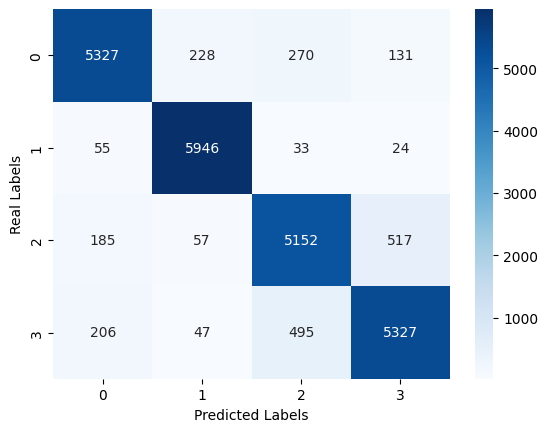

In [37]:
## Evaluate with Confusion Matrix

import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred_multiNB), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## BOW2: SVM 

In [38]:
from sklearn.svm import LinearSVC

linear_svc_clf = LinearSVC(max_iter=100000)
s = time.time()
linear_svc_clf.fit(X_train, y_train)
time_for_linear_svm = time.time() - s
print("Time to fit SVM:", time_for_linear_svm)

/home/ale/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Time to fit SVM : 20.02271580696106


/home/ale/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time fitting SVM -- molto più grande di un NaiveBayes, presumibilmente dovuto al grande dimensione dello spazio delle feature

In [ ]:
## Evaluate
y_pred_svc = linear_svc_clf.predict(X_test)
acc_bow_svm = accuracy_score(y_test, y_pred_svc)
print(classification_report(y_test, y_pred_svc))

In [ ]:
## Evaluate with Confusion Matrix

sns.heatmap(confusion_matrix(y_test,y_pred_svc), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

#### Linear SVM vs Naive Bayes 

* Naive Bayes regression fits to data much quicker
* Accuracy is roughly the same

## BOW3: Random forests

Per il random forest, utilizzeremo 300 alberi e i valori predefiniti per gli altri iperparametri:

- Criterio: gini
- Max_depth: nessuno, ovvero espanso fino a quando è puro o meno del minimo per il minimo di campioni
- Max_features: sqrt

Le random forest funzionano bootstrappando il dataset per addestrare alberi leggermente diversi, e poi tutti gli alberi vengono combinati per formare un modello di insieme, dove la decisione finale è una media ponderata ugualmente dei voti di tutti gli alberi. Il metodo di bootstrapping, insieme alla selezione casuale di un sottoinsieme di predittori da utilizzare per ogni suddivisione degli alberi, aiuta a decorrelare gli alberi in modo che offrano diverse prospettive sui dati. Gli alberi sono solitamente adattati trovando la migliore caratteristica e il suo miglior punto di divisione in ogni ramo dell'albero e scegliendo quello che minimizza meglio una certa funzione di costo, come l'entropia o la purezza di Gini.

Le foreste casuali aiutano a generalizzare un singolo albero decisionale altrimenti overfitted.

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(n_estimators=300, n_jobs = -1)
print(rf1)

s = time.time()
rf1.fit(X_train, y_train)
time_for_rf_1 = time.time() - s
print("Time to fit RF:", time_for_rf_1)

RandomForestClassifier(n_estimators=300, n_jobs=-1)


KeyboardInterrupt: 

In [ ]:
## Evaluate 
y_pred_rf1 = rf1.predict(X_test)
acc_bow_rf_untuned = accuracy_score(y_test, y_pred_rf1)
print(classification_report(y_test, y_pred_rf1))

In [ ]:
## Evaluate with Confusion Matrix

sns.heatmap(confusion_matrix(y_test,y_pred_rf1), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## BOW 3.2: Tuned RF

Ci sono molti iperparametri da ottimizzare nelle random forest.

Utilizzeremo la random search (cross validation) anziché la gridsearch, che potrebbe essere più veloce ed efficiente. Questo viene fatto selezionando punti casuali nello spazio degli iperparametri, invece di utilizzarli tutti.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

## Set up hyperparameter space 

param_grid = {
    'n_estimators' : [50, 150, 300, 450],
    'max_depth': [None, 10, 20, 40],
    'max_features': ['sqrt', 'log2'] 
}

In [ ]:
## Reinstantiate
rf = RandomForestClassifier(random_state = 42)

## Fit the random search object (i.e. start fitting rfs) and find the best model
s = time.time()

## init the RandomizedSearchCV object as random_search, stating the grid of params to test
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=10, ## number of parameter settings being sampled (number of combinations being tried)
                                   cv=3, n_jobs=-1, verbose=2, random_state=42)
## fit the random search object 
random_search.fit(X_train, y_train)
time_for_rf_2_hypertun = time.time() - s
print("Time for hyperparameter tuning via random search CV ", time_for_rf_2_hypertun)
best_rf = random_search.best_estimator_

Per risparmiare tempo durante l'addestramento della random search, optiamo per 10 iterazioni, ovvero 10 combinazioni testate.

In [ ]:
y_pred_rf2 = best_rf.predict(X_test)
acc_bow_rf_tuned = accuracy_score(y_test, y_pred_rf2)
print("Random Forest Results")
print(classification_report(y_test, y_pred_rf2))

In [ ]:
## For fair comparison, we want to also know the time taken to fit this new 'ideal' rf

# save tuned hyperparameters 
best_params_rf_2 = random_search.best_params_

# then init the rf model with the best params
rf_2_tuned = RandomForestClassifier(**best_params_rf_2) ## need ** to unpack the dictionary

## Time the duration for fitting
s = time.time()
rf_2_tuned.fit(X_train, y_train)
time_for_rf_tuned = time.time() - s
print('Time to fit tuned rf ', time_for_rf_tuned)

# Second set: Use different feature engineering -- TFIDF


TFIDF (Term Frequency-Inverse Document Frequency) assegna un peso maggiore ai termini che sono frequenti in un documento particolare ma non in molti documenti in generale. Questo è un modo diverso di vettorizzare un documento rispetto a BoW, che conta solo il numero di termini presenti in un documento specifico, senza considerare quanto comune o raro sia in altri documenti. L'approccio TFIDF tiene conto sia della frequenza del termine nel documento che dell'inverso della frequenza del termine in tutti i documenti, fornendo una rappresentazione più sofisticata e informativa del testo.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Use the TfidfVectorizer -- same parameters are before 
vectorizer = TfidfVectorizer(min_df=100, 
                             max_df=0.90, 
                             stop_words='english', 
                             max_features=10000)

X = vectorizer.fit_transform(preprocessed_text)

y = dataset['label']
## Same train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. MultinomialNB
s = time.time()
multiNB_clf = MultinomialNB()
multiNB_clf.fit(X_train, y_train)
time_for_multiNB_tfidf = time.time() - s
print("Time to fit Multinomial NaiveBayes:", time_for_multiNB_tfidf)

# 2. SVM Linear
s = time.time()
svm_linear_clf = LinearSVC(max_iter=1000)
svm_linear_clf.fit(X_train, y_train)
time_for_linear_svm_tfidf = time.time() - s
print("Time to fit SVM linear:", time_for_linear_svm_tfidf)


# Random Forest
s = time.time()
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
time_for_untuned_rf_tfidf = time.time() - s
print("Time to fit Random Forest:", time_for_untuned_rf_tfidf)

In [ ]:
## Evaluation
y_pred_multiNB = multiNB_clf.predict(X_test)
acc_tfidf_multiNB = accuracy_score(y_test, y_pred_rf1)
print("Multinomial Naive Bayes Results")
print(classification_report(y_test, y_pred_multiNB))

## SVM
y_pred_svm = svm_linear_clf.predict(X_test)
acc_tfidf_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Linear Results")
print(classification_report(y_test, y_pred_svm))

## RF 
y_pred_rf = rf_clf.predict(X_test)
acc_tfidf_rf_untuned = accuracy_score(y_test, y_pred_rf)
print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))

### Save the results so far

In [ ]:
import pandas as pd

model_comparisons = pd.DataFrame({
    'Vector_type' : ['BOW']*4 + ['TFIDF']*3,
    'Model': ["MultiNB", 'SVM', 'RF', 'RF tuned', 'MultiNB', 'SVM', 'RF'],
    'Time_to_fit' : [time_for_multiNB, time_for_linear_svm, time_for_rf_1, time_for_rf_tuned, time_for_multiNB_tfidf, time_for_linear_svm_tfidf, time_for_untuned_rf_tfidf],
    'Accuracy_score' : [acc_bow_multiNB, acc_bow_svm, acc_bow_rf_untuned, acc_bow_rf_tuned, acc_tfidf_multiNB, acc_tfidf_svm, acc_tfidf_rf_untuned],
    'No_words_predictors' : 10000
}
)

In [ ]:
print(model_comparisons.sort_values('Time_to_fit', ascending = True))

# What if we had reduced the number of words/predictors to 5000 (i.e. halving the number of columns)?

Will this still be enough information for our models to perform well?

## BOW (5000 predictors)

In [ ]:
## Create instance of BOW vectorizer
bow_vectorizer = CountVectorizer(stop_words = 'english', ## use stopwords again, although we had used it from spacy already
                                max_features = 5000) ## now half only

## Apply vectorisers to data
X = bow_vectorizer.fit_transform(preprocessed_text)

## Check shape 
print(X.shape)

## Train test split
y = dataset['label']  # Assuming 'label' is the column with classes' labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## FIT NB MODEL ==========================================================
s = time.time()
nb_clf_reduced_preds = MultinomialNB()
nb_clf_reduced_preds.fit(X_train, y_train)
print("Time to fit Multinomial Naive Bayes:", time.time() - s)

In [ ]:
## EVALUATE NB MODEL --------------------------------------------------------
from sklearn.metrics import classification_report
y_pred_multiNB_reduced_preds = nb_clf_reduced_preds.predict(X_test)
print(classification_report(y_test, y_pred_multiNB_reduced_preds))

## TFIDF (5000 predictors)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Use the TfidfVectorizer -- same parameters are before 
vectoriser = TfidfVectorizer(stop_words='english', max_features=5000)

X = vectoriser.fit_transform(preprocessed_text)

y = dataset['label']
## Same train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. MultinomialNB
s = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
print("Time to fit Multinomial NaiveBayes:", time.time() - s)

In [ ]:
## EVALUATE NB MODEL --------------------------------------------------------
from sklearn.metrics import classification_report
y_pred_multiNB_reduced_preds = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred_multiNB_reduced_preds))

### When feature space was reduced by half, 

* Naive Bayes non ha sofferto molto in termini di tempo impiegato per l'addestramento o di accuratezza.
* TFIDF sembrafunzionare meglio (leggermente) rispetto a BoW, e questo ha senso poiché TFIDF cattura più informazioni rispetto a BoW. 

# Word embedding methods 


Invece di utilizzare metodi che vettorizzano i documenti basandosi sulle parole, trattando le parole come indipendenti (come predittori indipendenti), cerchiamo di catturare semantica e significati delle parole per vedere se possiamo migliorare il modello.

## 1. Using pre-trained word embeddings

Proveremo a utilizzare il modello GloVe. GloVe è stato sviluppato per generare word embeddings ed è progettato per ottenere relazioni semantiche tra le parole. Pertanto, in questo spazio, le parole con significati simili tenderanno ad essere più vicine in questo nuovo spazio delle feature.

In [ ]:
import gensim.downloader 

glove_model = gensim.downloader.load('glove-wiki-gigaword-100')

In [ ]:
## Check some stuff from glove 
print('Vector sizes are ', glove_model.vector_size) ## 100 dim for feature space -- just nice?

Il nostro spazio delle feature è di 100 dimensioni. Se confrontato con le dimensioni di BoW e TFIDF, dove avevamo scelto di includere circa 10.000 parole (dimensioni), questo è molto ristretto. Tuttavia, nel contesto delle rappresentazioni semantiche come GloVe, anche uno spazio delle feature relativamente piccolo può catturare informazioni significative e complesse sulle relazioni semantiche tra le parole.

Possiamo testarlo calcolando la cosine similarity (ovvero quanto due parole sono simili nello spazio delle caratteristiche).

In [ ]:
## Test it out -- get word vectors
word_vec = glove_model['word']
sent_vec = glove_model['sentence']

## shape 
glove_model['word'].shape ## 100 column space that the words exist in 

## Test similarity 
print('cosine sim between "word" and "sentence" ', glove_model.cosine_similarities(word_vec, [sent_vec]))
print('cosine sim between "word" and "potato" ', glove_model.cosine_similarities(word_vec, [glove_model['potato']]))

## Test on multiple words 
glove_model.cosine_similarities(word_vec, [glove_model['potato'], 
                                          glove_model['car'],
                                          glove_model['language']])

## Test on the word banana
glove_model.cosine_similarities(glove_model['banana'], [glove_model['apple'],
                                                       glove_model['food'],
                                                       glove_model['object'],
                                                       glove_model['computers']])
## result -- the words get less and less related

In [ ]:
## Checking that word exists in the vocab
glove_vocab = glove_model.key_to_index

## Check type 
print(type(glove_vocab)) ## glove_vocab is a dictionary instead of a list 

## Get vocab size
print('Size of vocab ', len(glove_vocab)/1000, ' thousand')

## See some words
list_of_keys = list(glove_vocab.keys())
list_of_values = list(glove_vocab.values())

In [ ]:
## Take a peek at the keys and values of the vocab
print(list_of_keys[0:10])
print(list_of_values[0:10])

Curiosamente, **anche la punteggiatura ha degli embeddings**, come visto in precedenza. Esaminiamo più da vicino queste rappresentazioni e cerchiamo 'token' simili alla punteggiatura.

In [ ]:
import numpy as np

## Word embedding for comma 
glove_model[',']
## Cosine similarities btn punctuations 
print('Cos sim btn "," and "." ', np.dot(glove_model[','], glove_model['.']))
print('Cos sim btn "," and "?" ', np.dot(glove_model[','], glove_model['?']))

## Cosine similarities btn punctuations and words 
print('Cos sim btn "," and "hello" ', np.dot(glove_model[','], glove_model['hello']))
print('Cos sim btn "," and "pause" ', np.dot(glove_model[','], glove_model['pause']))
print('Cos sim btn "," and "comma" ', np.dot(glove_model[','], glove_model['pause']))

In [ ]:
## Most similar terms to comma
glove_model.similar_by_word(",")

# Third feature engineering: use the average word embedding of the sentence from GloVe

Prima di tutto, dobbiamo trasformare i testi in vettori di parole, poiché ogni testo è composto da molte parole. Ciò comporterà la creazione di molti vettori. Per semplicità, prenderemo la media dei vettori per ottenere un singolo vettore per ciascun testo. Questo approccio ha alcune limitazioni, poiché potrebbe 'diluire' il significato di alcune parole importanti, ma procederemo con questo metodo per ora.

In [ ]:
def get_avg_embedding(text): ## Takes in a single text, instead of a list of texts 
    ## Tokenise first, get indiv words 
    words = text.split()
    
    ## Get list of word vectors (this would result in many word vectors)
    vectors = [glove_model[word] for word in words if word in glove_vocab] ## make sure that the word is covered by the model
    
    ## Normalize the vectors for each word 
    normalized_vectors = [vector/np.linalg.norm(vector) for vector in vectors] if vectors else None ## If there was no vector in vectors, then return None
    
    ## Take the average of all 
    avg_vector = sum(normalized_vectors)/len(normalized_vectors) if normalized_vectors else None
    
    return(avg_vector)

## Since we allowed for None in cases where there was no vector (this happens if 
# the text had no words that was recognised by the Glove Model), we should make sure
# to check the list of avg embeddings to see if there are empty vectors

In [ ]:
s = time.time()
avg_embeddings_X = [get_avg_embedding(text) for text in preprocessed_texts]
print('Time taken to get avg embeddings, via list comprehension method', time.time()- s)

Questo comporta essenzialmente l'utilizzo di un ciclo for nella list comprehension, il che è molto lento. Un modo più veloce sarebbe utilizzare un metodo parallelizzato, tramite il pacchetto 'pandarallel', che integra il framework di Pandas. Vediamo se risulta più veloce.

In [ ]:
import pandarallel

pandarallel.initialize(progress_bar=True)

In [ ]:
s = time.time()
dataset['avg_embeddings'] = dataset.text_cleaned.parallel_apply(get_avg_embedding)
time_for_pandarallel = time.time() - s
print('Time taken to get avg embeddings, via pandarallel method', time_for_pandarallel)

In [ ]:
print('Percentage decrease in time taken ', (172 - time_for_pandarallel)/172 * 100, ' %') 

Pertanto, l'uso di "pandarallel" comporta una significativa riduzione del tempo impiegato per ottenere la rappresentazione vettoriale media del testo.

Check dei risultati del processo di embedding

In [ ]:
print(type(avg_embeddings_X))
print(len(avg_embeddings_X)) ## this is the number of documents 

## Look at one of the embeddings 
print(type(avg_embeddings_X[0])) ## List of np.arrays
avg_embeddings_X[0].shape ## Each embedding has 100 length, as expected 

In [ ]:
## Check if any vector is empty or None 

## Recall that if the words in our text dont exist in the glove vocab, the function returns None
## Test the function on some gibberish and see if it returns None
print(get_avg_embedding("sdjfas fasdfjsdfsajfls"))

## Check if there are any None(s) in our result (from the df version)
print("None in DF ", dataset.avg_embeddings.isna().sum())

## Check again from the list version
print("None in list ", sum(1 for vec in avg_embeddings_X if vec is None))

Sembra che ci siano vettori mancanti, probabilmente a causa di parole non riconosciute. Diamo un'occhiata più da vicino a questi casi.

In [ ]:
dataset[dataset.avg_embeddings.isna()][['text', 'text_cleaned', 'label', 'avg_embeddings']]

Vediamo che sono vuoti poiché erano URL che sono stati rimossi dalla fase di preelaborazione (ad esempio, rimuovendo termini non alfanumerici, rimuovendo le stopwords) o semplici casi di una sola parola. Possiamo rimuoverli.

In [ ]:
## Drop NAs/ Nones 
print(dataset.shape)
print(dataset.dropna(subset = ['avg_embeddings']).shape) ## 13 removed 

## Drop 
data_no_nas = dataset.dropna(subset = ['avg_embeddings'])

## Check
print(data_no_nas.head())

## Repeat modelling workflow : train test split and fitting on the new X vector embeddings data 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Rmb to use the data without nas, so that there is no inconsistency in the set of X vectors
X = data_no_nas.avg_embeddings.to_list()

y = data_no_nas['label']
## Same train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Check if the data is prepared correctly/ in the right format 
print(type(X_train)) ## this is a list -- need to convert to np array
print(type(y_train))

Attualmente, i nostri dati X sono nella forma di una lista di liste. Per utilizzare gli algoritmi di sklearn, dobbiamo prima convertirli in array numpy bidimensionali.

In [ ]:
print(len(X_train))

## Convert to 2D np arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

## Check shape 
print(X_train.shape)
print(X_test.shape) ## our data is now in 2D arrays, so it is okay

In [ ]:
# 1. MultinomialNB
s = time.time()
multiNB_clf = MultinomialNB()
multiNB_clf.fit(X_train, y_train)
time_for_multiNB_glove = time.time() - s
print("Time to fit Multinomial NaiveBayes:", time_for_multiNB_glove)

# 2. SVM Linear
s = time.time()
svm_linear_clf = LinearSVC(max_iter=1000)
svm_linear_clf.fit(X_train, y_train)
time_for_linear_svm_glove = time.time() - s
print("Time to fit SVM linear:", time_for_linear_svm_glove)


# Random Forest
s = time.time()
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
time_for_untuned_rf_glove = time.time() - s
print("Time to fit Random Forest:", time_for_untuned_rf_glove)


Questo rappresenta un miglioramento significativo rispetto ad alcuni dei metodi precedenti. Questo è probabilmente dovuto allo spazio di predittori più piccolo.

In [ ]:
## Model evaluations
print(classification_report(multiNB_clf.predict(X_test), y_test))
print(classification_report(svm_linear_clf.predict(X_test), y_test))
print(classification_report(rf_clf.predict(X_test), y_test))

## Results of GloVe representations

Anche se molto più veloci nell'addestrare i modelli, soffre notevolmente in termini di accuratezza.

### Natura della rappresentazione

Mentre BoW e TFIDF catturano l'occorrenza delle parole indipendentemente, il metodo GloVe che abbiamo utilizzato ha essenzialmente preso il 'centro' dei vettori embedded delle parole di ciascun testo, poiché ne abbiamo calcolato la media. Questo potrebbe finire per annullare parte del significato delle parole, perdendo in granularità. È anche possibile che alcune delle parole, che erano cruciali nel determinare l'esito del testo nel classificare una notizia, non fossero nel vocabolario del modello GloVe e quindi non fossero considerate nei dati, causando una perdita di informazioni importanti.

# Converting text to sequences with Keras, with embedding layer in the neural network

Come funziona:

* **Codifica di intera:** il metodo `text_to_sequences` converte i testi in interi in base al vocabolario del corpus.

* Abbiamo quindi una **sequenza di interi** (text to sequences), poiché i modelli non possono comprendere le parole ma solo i numeri.

* Ognuno di questi vettori viene poi riempito in modo che contenga un numero consistente di interi.

* Il primo strato della rete neurale sarà il livello di embedding (**embedding layer**), che è un tipo speciale di livello che *cerca ciascun intero (indice delle parole) e lo mappa in un vettore denso*, che è la rappresentazione semantica, simile a quella che abbiamo utilizzato con GloVe.

* Poi colleghiamo uno strato completamente connesso, dove l'ultimo strato sarà composto da 4 neuroni con una funzione di attivazione softmax, poiché stiamo effettuando una classificazione di 4 classi.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
## Instantiate the keras tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token = '<00v>') ## this is for out of vocab
## terms -- therefore when testing, if the model sees a word that has not been trained, 
## it will map it to 1 instead of removing the term 

In [ ]:
## Fit the tokenizer to the corpus 
tokenizer.fit_on_texts(dataset.text_cleaned) ## use fit on texts method as we have a series or list of texts
word_index = tokenizer.word_index